In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
data = pd.read_csv("international-airline-passengers.csv", usecols = [1], engine = "python", skipfooter = 3)

In [28]:
data.shape

(144, 1)

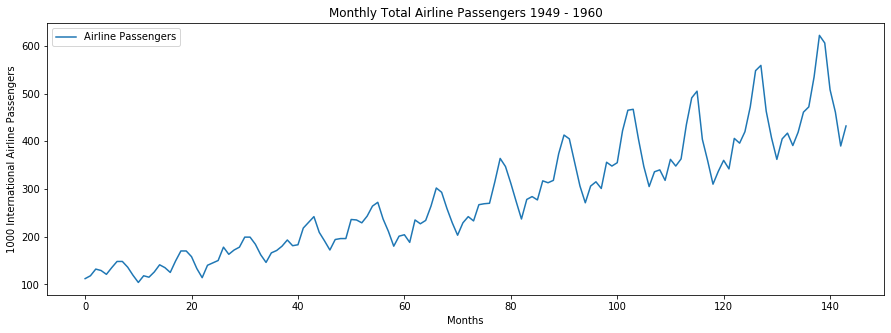

In [29]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data)

In [57]:
dataset[0:5]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]])

In [58]:
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (86, 58)


In [59]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [60]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(84, 1)
New training data shape:
(84, 1, 1)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout

In [62]:
model = Sequential()
model.add(LSTM(4, input_shape = (1, window_size)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
model.fit(train_X, train_Y, epochs = 100, batch_size = 1)

Epoch 1/100
84/84 [==============================] - 2s 26ms/sample - loss: 0.0179
Epoch 2/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0079
Epoch 3/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0068
Epoch 4/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0063
Epoch 5/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0057
Epoch 6/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0052
Epoch 7/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0048
Epoch 8/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0043
Epoch 9/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0039
Epoch 10/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0035
Epoch 11/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0032
Epoch 12/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0028
Epoch 13/100

84/84 [==============================] - 0s 2ms/sample - loss: 0.0017
Epoch 100/100
84/84 [==============================] - 0s 2ms/sample - loss: 0.0017


In [63]:
from sklearn.metrics import mean_squared_error
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 21.95 RMSE
Test data score: 48.19 RMSE


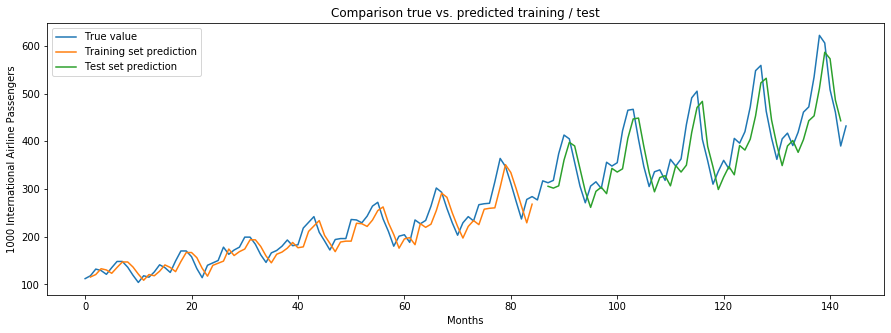

In [64]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

** Exercise from : https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras/data**